In [687]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [688]:
games_df = pd.read_csv('Downloads/archive/Games.csv', low_memory=False)
player_stats_df = pd.read_csv('Downloads/archive/PlayerStatistics.csv', low_memory=False)
team_stats_df = pd.read_csv('Downloads/archive/TeamStatistics.csv', low_memory=False)

for df in [games_df, team_stats_df, player_stats_df]:
    df.columns = df.columns.str.strip().str.lower()

In [689]:
# Convert dates
games_df['gamedate'] = pd.to_datetime(games_df['gamedate'], errors='coerce')
team_stats_df['gamedate'] = pd.to_datetime(team_stats_df['gamedate'], errors='coerce')
player_stats_df['gamedate'] = pd.to_datetime(player_stats_df['gamedate'], errors='coerce')

team_stats_df = team_stats_df.sort_values(by=['teamid', 'gamedate'])
player_stats_df = player_stats_df.sort_values(by=['personid', 'gamedate'])

In [690]:
# === TEAM SEASON-TO-DATE AVERAGES ===
team_stat_cols = ['teamscore', 'assists', 'reboundstotal', 'turnovers', 'fieldgoalspercentage', 'plusminuspoints']

for col in team_stat_cols:
    team_stats_df[f'avg_{col}_season'] = (
        team_stats_df.groupby('teamid')[col]
        .expanding()
        .mean()
        .shift(1)
        .reset_index(level=0, drop=True)
    )

# --- Advanced metrics ---
FG = team_stats_df['fieldgoalsmade']
FGA = team_stats_df['fieldgoalsattempted']
TP = team_stats_df['threepointersmade']

team_stats_df['eFG_percent_scaled'] = 2 * ((FG + 0.5 * TP) / FGA.replace(0, np.nan))
team_stats_df['turnover_ratio_scaled'] = 2 * team_stats_df['turnovers']
team_stats_df['offensive_rebounds_scaled'] = 2 * team_stats_df['reboundsoffensive']
team_stats_df['fta_rate_scaled'] = 2 * team_stats_df['freethrowsattempted']

team_avg_cols = [f'avg_{col}_season' for col in team_stat_cols] + [
    'eFG_percent_scaled', 'turnover_ratio_scaled', 'offensive_rebounds_scaled', 'fta_rate_scaled'
]
team_avg = team_stats_df[['gameid', 'teamid'] + team_avg_cols]

In [691]:
# === PLAYER SEASON-TO-DATE AVERAGES ===
# --- Player stats to include ---
player_stat_cols = ['points', 'assists', 'reboundstotal', 'numminutes', 'plusminuspoints']

# Convert to numeric
for col in player_stat_cols:
    player_stats_df[col] = pd.to_numeric(player_stats_df[col], errors='coerce')

# Compute season-to-date averages per player
for col in player_stat_cols:
    player_stats_df[f'avg_{col}_season'] = (
        player_stats_df.groupby('personid')[col]
        .expanding()
        .mean()
        .shift(1)
        .reset_index(level=0, drop=True)
    )

# Aggregate player stats per team per game (mean of player season stats)
player_team_avg = player_stats_df.groupby(['gameid', 'playerteamname']).agg({
    f'avg_{col}_season': 'mean' for col in player_stat_cols
}).reset_index()

In [692]:
# --- Merge with games_df ---
# Merge team averages
home_team = team_avg.copy().add_prefix('home_')
away_team = team_avg.copy().add_prefix('away_')

merged = games_df.merge(home_team, left_on=['gameid', 'hometeamid'], right_on=['home_gameid', 'home_teamid'], how='inner')
merged = merged.merge(away_team, left_on=['gameid', 'awayteamid'], right_on=['away_gameid', 'away_teamid'], how='inner')

# Merge player averages
home_player = player_team_avg.copy().add_prefix('home_')
away_player = player_team_avg.copy().add_prefix('away_')

merged = merged.merge(home_player, left_on=['gameid', 'hometeamname'], right_on=['home_gameid', 'home_playerteamname'], how='left')
merged = merged.merge(away_player, left_on=['gameid', 'awayteamname'], right_on=['away_gameid', 'away_playerteamname'], how='left')

# Clean up
drop_cols = [col for col in merged.columns if '_gameid' in col or '_teamid' in col or 'playerteamname' in col]
merged = merged.drop(columns=drop_cols)
merged = merged.dropna()

In [693]:
# --- Labels ---
merged['home_win'] = (merged['homescore'] > merged['awayscore']).astype(int)
merged['margin'] = merged['homescore'] - merged['awayscore']

# === Exponential weight decay by year ===
max_year = merged['gamedate'].dt.year.max()
merged['years_ago'] = max_year - merged['gamedate'].dt.year
alpha = 0.3  # decay strength: 0.2 = slow, 0.5 = faster
merged['sample_weight'] = np.exp(-alpha * merged['years_ago'])

# --- Final feature set ---
X = merged.select_dtypes(include=[np.number]).drop(columns=['home_win', 'margin'])
y_class = merged['home_win']
y_reg = merged['margin']

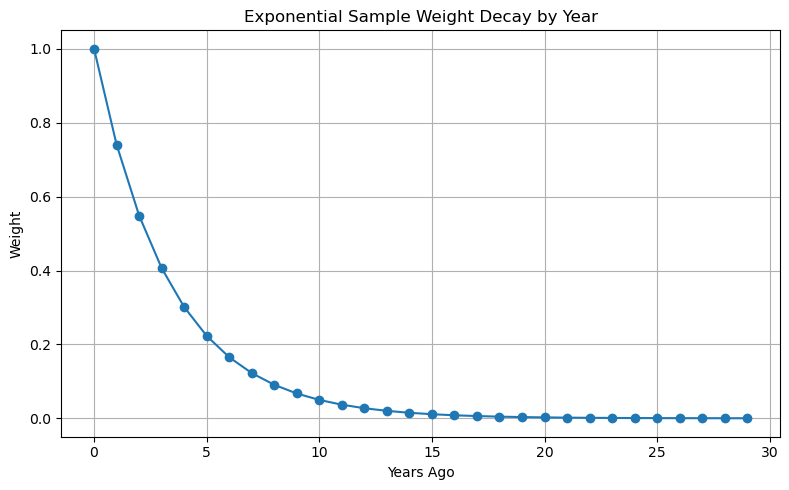

In [694]:
years_ago = np.arange(0, 30)
weights = np.exp(-alpha * years_ago)

plt.figure(figsize=(8, 5))
plt.plot(years_ago, weights, marker='o')
plt.title("Exponential Sample Weight Decay by Year")
plt.xlabel("Years Ago")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

### Train/Test Split

In [696]:
# --- Train/test split ---
X_train, X_test, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

### Train Random Forest Classifier

Classifier Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.73      0.85        15

    accuracy                           0.82        22
   macro avg       0.82      0.87      0.81        22
weighted avg       0.88      0.82      0.82        22

Regressor RMSE: 5.205129026433272


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


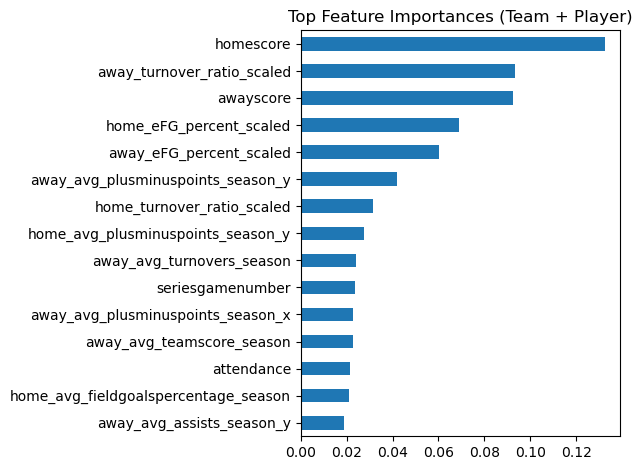

In [698]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_cls, sample_weight=merged.loc[X_train.index, 'sample_weight'])

print("Classifier Accuracy:", accuracy_score(y_test_cls, clf.predict(X_test)))
print(classification_report(y_test_cls, clf.predict(X_test)))

# --- Train regressor ---
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train_reg, sample_weight=merged.loc[X_train.index, 'sample_weight'])
print("Regressor RMSE:", mean_squared_error(y_test_reg, reg.predict(X_test), squared=False))

# === FEATURE IMPORTANCE ===
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("Top Feature Importances (Team + Player)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [699]:
print(games_df['gamedate'].min(), games_df['gamedate'].max())

1946-11-26 19:00:00 2025-04-28 22:00:00


In [700]:
joblib.dump(model_classifier, 'nba_win_classifier_3.0.pkl')
joblib.dump(model_regressor, 'nba_margin_regressor_2.0.pkl')

['nba_margin_regressor_2.0.pkl']